### Instalações

In [1]:
!pip install geopandas esda libpysal matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 66.7 MB/s eta 0:00:00


In [2]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 11.7 MB/s eta 0:00:00


### Questões A e B

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import geopandas as gpd
from unidecode import unidecode

# Caminhos para os arquivos
shapefile_path = '/content/GO_Municipios_2022.zip'
votos_path = '/content/drive/My Drive/votacao_2022_GO.csv'

# Carregar shapefile
geo_municipios = gpd.read_file(shapefile_path)

# Carregar arquivo de votos
votos = pd.read_csv(votos_path, sep=';', encoding='latin-1', usecols=['DS_CARGO', 'SQ_CANDIDATO', 'CD_MUNICIPIO', 'NM_MUNICIPIO', 'NR_VOTAVEL', 'NM_VOTAVEL', 'QT_VOTOS'])

In [5]:
df_deputados = votos[
    (votos['DS_CARGO'] == 'DEPUTADO FEDERAL') &
    (~votos['NM_VOTAVEL'].isin(['VOTO BRANCO', 'VOTO NULO']))
]
df_deputados = df_deputados[['NM_MUNICIPIO', 'NR_VOTAVEL', 'NM_VOTAVEL', 'QT_VOTOS']]

In [6]:
# Renomear a coluna NM_MUN no GeoDataFrame para NM_MUNICIPIO para alinhar os nomes
geo_municipios = geo_municipios.rename(columns={'NM_MUN': 'NM_MUNICIPIO'})

# Normalizar os nomes dos municípios em ambos os DataFrames
geo_municipios['NM_MUNICIPIO'] = geo_municipios['NM_MUNICIPIO'].apply(unidecode).str.upper()
votos['NM_MUNICIPIO'] = votos['NM_MUNICIPIO'].apply(unidecode).str.upper()

In [7]:
# Identificar municípios presentes em votos mas ausentes no GeoDataFrame
municipios_votos_nao_encontrados = set(votos['NM_MUNICIPIO']) - set(geo_municipios['NM_MUNICIPIO'])
print("Municípios em votos, mas não no GeoDataFrame:")
print(municipios_votos_nao_encontrados)

# Identificar municípios presentes no GeoDataFrame mas ausentes em votos
municipios_geo_nao_encontrados = set(geo_municipios['NM_MUNICIPIO']) - set(votos['NM_MUNICIPIO'])
print("\nMunicípios no GeoDataFrame, mas não em votos:")
print(municipios_geo_nao_encontrados)

Municípios em votos, mas não no GeoDataFrame:
{'SAO JOAO D ALIANCA', 'SITIO D ABADIA'}

Municípios no GeoDataFrame, mas não em votos:
{"SAO JOAO D'ALIANCA", "SITIO D'ABADIA"}


In [8]:
# Corrigir manualmente os nomes no GeoDataFrame para alinhar com os nomes no DataFrame de votos
geo_municipios['NM_MUNICIPIO'] = geo_municipios['NM_MUNICIPIO'].replace({
    "SITIO D'ABADIA": "SITIO D ABADIA",
    "SAO JOAO D'ALIANCA": "SAO JOAO D ALIANCA"
})

In [9]:
# Filtrando apenas candidados a deputado federal
df_candidatos = votos[
    (votos['DS_CARGO'] == 'DEPUTADO FEDERAL') &
    (~votos['SQ_CANDIDATO'].isin([-3]))
]
df_candidatos = df_candidatos[['NM_MUNICIPIO', 'NR_VOTAVEL', 'NM_VOTAVEL', 'QT_VOTOS']]

In [10]:
df_candidatos['QT_VOTOS'] = df_candidatos['QT_VOTOS'].astype('int32')

In [11]:
# Agrupar por NM_VOTAVEL e NM_MUNICIPIO, somando os votos (QT_VOTOS)
df_votos_candidatos = df_candidatos.groupby(['NM_VOTAVEL','NM_MUNICIPIO'])['QT_VOTOS'].sum().reset_index()

In [12]:
# Unir os dados espaciais e os votos por candidato
gdf_candidatos = geo_municipios.merge(df_votos_candidatos, on="NM_MUNICIPIO", how="inner")

In [13]:
geo_municipios.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   CD_MUN        246 non-null    object  
 1   NM_MUNICIPIO  246 non-null    object  
 2   SIGLA_UF      246 non-null    object  
 3   AREA_KM2      246 non-null    float64 
 4   geometry      246 non-null    geometry
dtypes: float64(1), geometry(1), object(3)
memory usage: 9.7+ KB


In [25]:
votos_por_municipio = df_candidatos.groupby('NM_MUNICIPIO')['QT_VOTOS'].sum().reset_index()
print(votos_por_municipio)

           NM_MUNICIPIO  QT_VOTOS
0       ABADIA DE GOIAS      8900
1             ABADIANIA      8407
2               ACREUNA     11387
3             ADELANDIA      2154
4    AGUA FRIA DE GOIAS      3367
..                  ...       ...
241              VARJAO      2814
242          VIANOPOLIS      8197
243      VICENTINOPOLIS      4996
244            VILA BOA      2667
245       VILA PROPICIO      3855

[246 rows x 2 columns]


In [26]:
print(votos.head())
print(votos['NM_VOTAVEL'].unique())  # Validar se realmente aparece

   CD_MUNICIPIO NM_MUNICIPIO           DS_CARGO  NR_VOTAVEL  \
0         95710    RIO VERDE         GOVERNADOR          95   
1         94196   ITAPURANGA         GOVERNADOR          95   
2         93734      GOIANIA  DEPUTADO ESTADUAL       28888   
3         93734      GOIANIA         GOVERNADOR          95   
4         93734      GOIANIA  DEPUTADO ESTADUAL       28888   

                     NM_VOTAVEL  QT_VOTOS  SQ_CANDIDATO  
0                   VOTO BRANCO        25            -1  
1                   VOTO BRANCO         4            -1  
2  JOAO PEREIRA DA SILVA JUNIOR         1   90001644176  
3                   VOTO BRANCO         8            -1  
4  JOAO PEREIRA DA SILVA JUNIOR         1   90001644176  
['VOTO BRANCO' 'JOAO PEREIRA DA SILVA JUNIOR' 'LEONARDO CAIRO RIZZO' ...
 'ANDRÉ ANTÔNIO FERREIRA' 'EDMILSON CANUTO'
 'RAIMUNDA FRANCISCA PEREIRA DA SILVA']


In [27]:
votos['NM_VOTAVEL'] = votos['NM_VOTAVEL'].str.strip().str.upper()
print(votos['NM_VOTAVEL'].unique())

['VOTO BRANCO' 'JOAO PEREIRA DA SILVA JUNIOR' 'LEONARDO CAIRO RIZZO' ...
 'ANDRÉ ANTÔNIO FERREIRA' 'EDMILSON CANUTO'
 'RAIMUNDA FRANCISCA PEREIRA DA SILVA']


In [28]:
print(f"Total de registros no arquivo: {len(df_candidatos)}")

Total de registros no arquivo: 722943


In [29]:
gayer = df_candidatos[df_candidatos['NM_VOTAVEL'] == 'GUSTAVO GAYER MACHADO DE ARAUJO']
print(gayer)

                  NM_MUNICIPIO  NR_VOTAVEL                       NM_VOTAVEL  \
150900                 GOIANIA        2210  GUSTAVO GAYER MACHADO DE ARAUJO   
150902                TRINDADE        2210  GUSTAVO GAYER MACHADO DE ARAUJO   
150904                 FORMOSA        2210  GUSTAVO GAYER MACHADO DE ARAUJO   
150905                ANAPOLIS        2210  GUSTAVO GAYER MACHADO DE ARAUJO   
150907            FIRMINOPOLIS        2210  GUSTAVO GAYER MACHADO DE ARAUJO   
...                        ...         ...                              ...   
1910608               TRINDADE        2210  GUSTAVO GAYER MACHADO DE ARAUJO   
1911007            TURVELANDIA        2210  GUSTAVO GAYER MACHADO DE ARAUJO   
1911009  AGUAS LINDAS DE GOIAS        2210  GUSTAVO GAYER MACHADO DE ARAUJO   
1911012                GOIANIA        2210  GUSTAVO GAYER MACHADO DE ARAUJO   
1911014    VALPARAISO DE GOIAS        2210  GUSTAVO GAYER MACHADO DE ARAUJO   

         QT_VOTOS  
150900         23  
150902     

In [30]:
print(f"Total de registros para Gustavo Gayer: {len(gayer)}")

Total de registros para Gustavo Gayer: 14377


In [31]:
votos_por_municipio_gayer = gayer.groupby(['NM_MUNICIPIO', 'NM_VOTAVEL'])['QT_VOTOS'].sum().reset_index()
print(votos_por_municipio_gayer.head())

         NM_MUNICIPIO                       NM_VOTAVEL  QT_VOTOS
0     ABADIA DE GOIAS  GUSTAVO GAYER MACHADO DE ARAUJO       488
1           ABADIANIA  GUSTAVO GAYER MACHADO DE ARAUJO       326
2             ACREUNA  GUSTAVO GAYER MACHADO DE ARAUJO       243
3           ADELANDIA  GUSTAVO GAYER MACHADO DE ARAUJO        56
4  AGUA FRIA DE GOIAS  GUSTAVO GAYER MACHADO DE ARAUJO       135


In [32]:
geo_gayer = geo_municipios.merge(votos_por_municipio_gayer, on='NM_MUNICIPIO', how='left')
print(geo_gayer.head())

    CD_MUN        NM_MUNICIPIO SIGLA_UF  AREA_KM2  \
0  5200050     ABADIA DE GOIAS       GO   143.357   
1  5200100           ABADIANIA       GO  1044.555   
2  5200134             ACREUNA       GO  1566.742   
3  5200159           ADELANDIA       GO   115.385   
4  5200175  AGUA FRIA DE GOIAS       GO  2023.636   

                                            geometry  \
0  POLYGON ((-49.43754 -16.86015, -49.43849 -16.8...   
1  POLYGON ((-48.67246 -16.28556, -48.67248 -16.2...   
2  POLYGON ((-50.07007 -17.48691, -50.06993 -17.4...   
3  POLYGON ((-50.17913 -16.43049, -50.17928 -16.4...   
4  POLYGON ((-47.85694 -14.76464, -47.85674 -14.7...   

                        NM_VOTAVEL  QT_VOTOS  
0  GUSTAVO GAYER MACHADO DE ARAUJO       488  
1  GUSTAVO GAYER MACHADO DE ARAUJO       326  
2  GUSTAVO GAYER MACHADO DE ARAUJO       243  
3  GUSTAVO GAYER MACHADO DE ARAUJO        56  
4  GUSTAVO GAYER MACHADO DE ARAUJO       135  


In [33]:
print(f"Tamanho do GeoDataFrame: {geo_gayer.memory_usage(deep=True).sum() / 1e6} MB")

Tamanho do GeoDataFrame: 0.073873 MB


In [34]:
from libpysal.weights import Queen

# Criar matriz de pesos para o subconjunto
weights_gayer = Queen.from_dataframe(geo_gayer)

# Identificar componentes desconectados
components = weights_gayer.component_labels
connected_indices = [i for i, label in enumerate(components) if label == 0]  # Filtra apenas o maior componente

# Filtrar apenas os pontos conectados
geo_gayer_connected = geo_gayer.iloc[connected_indices]

# Criar uma nova matriz de pesos com os pontos conectados
weights_gayer_connected = Queen.from_dataframe(geo_gayer_connected)

print(f"Total de municípios conectados: {len(geo_gayer_connected)}")

<ipython-input-34-ad0feaf18166>:4: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  weights_gayer = Queen.from_dataframe(geo_gayer)
<ipython-input-34-ad0feaf18166>:14: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  weights_gayer_connected = Queen.from_dataframe(geo_gayer_connected)


Total de municípios conectados: 246


In [35]:
from esda.moran import Moran

# Obter os valores de votos como array usando a coluna correta
votos_values = geo_gayer_connected['QT_VOTOS'].fillna(0).values

# Calcular o Índice de Moran
moran = Moran(votos_values, weights_gayer_connected)

# Exibir os resultados
print(f"Índice de Moran: {moran.I}")
print(f"p-value: {moran.p_sim}")
print(f"z-score: {moran.z_sim}")

Índice de Moran: 0.04854641108766978
p-value: 0.023
z-score: 3.6397003892312325


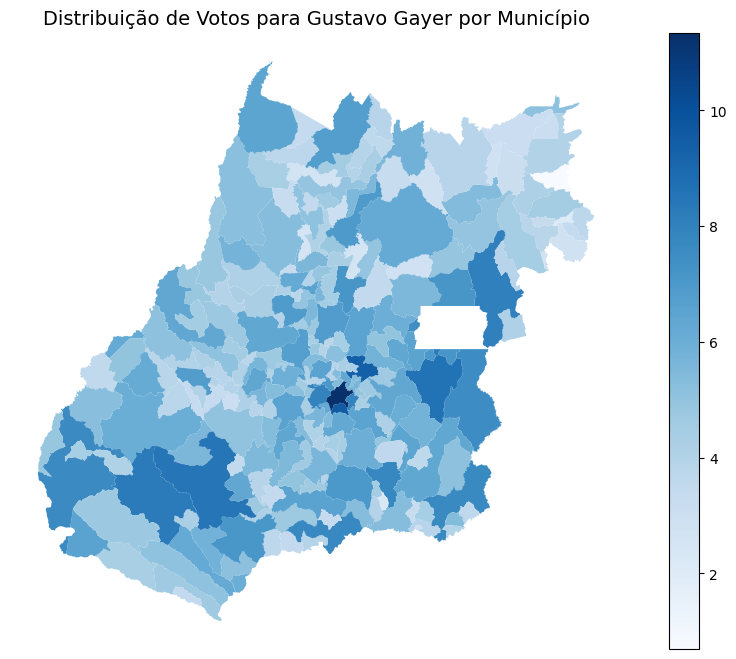

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors

# Plotar o mapa coroplético
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Criar uma coluna logarítmica
geo_gayer_connected = geo_gayer.copy()
geo_gayer_connected['QT_VOTOS_log'] = np.log(geo_gayer_connected['QT_VOTOS'])

# Definir o colormap
vmin_log = np.log(geo_gayer_connected['QT_VOTOS'].min())
vmax_log = np.log(geo_gayer_connected['QT_VOTOS'].max())
norm = colors.Normalize(vmin=vmin_log, vmax=vmax_log)

geo_gayer_connected.plot(
    column='QT_VOTOS_log',
    cmap='Blues',
    legend=True,
    ax=ax
)
ax.set_title('Distribuição de Votos para Gustavo Gayer por Município', fontsize=14)
ax.axis('off')
plt.show()

Candidato ALYSSON FRANCISCO DE LIMA, que não foi eleito

In [37]:
# Filtrar os votos para o candidato não eleito
votos_nao_eleito = df_candidatos[df_candidatos['NM_VOTAVEL'] == 'ALYSSON FRANCISCO DE LIMA']

In [38]:
# Agrupar os votos por município
votos_por_municipio_nao_eleito = votos_nao_eleito.groupby(['NM_MUNICIPIO', 'NM_VOTAVEL'])['QT_VOTOS'].sum().reset_index()
print(votos_por_municipio_nao_eleito.head())

            NM_MUNICIPIO                 NM_VOTAVEL  QT_VOTOS
0        ABADIA DE GOIAS  ALYSSON FRANCISCO DE LIMA        54
1              ABADIANIA  ALYSSON FRANCISCO DE LIMA         4
2              ADELANDIA  ALYSSON FRANCISCO DE LIMA         2
3     AGUA FRIA DE GOIAS  ALYSSON FRANCISCO DE LIMA        11
4  AGUAS LINDAS DE GOIAS  ALYSSON FRANCISCO DE LIMA         3


In [39]:
geo_nao_eleito = geo_municipios.merge(votos_por_municipio_nao_eleito, on='NM_MUNICIPIO', how='left')
print(geo_nao_eleito.head())

    CD_MUN        NM_MUNICIPIO SIGLA_UF  AREA_KM2  \
0  5200050     ABADIA DE GOIAS       GO   143.357   
1  5200100           ABADIANIA       GO  1044.555   
2  5200134             ACREUNA       GO  1566.742   
3  5200159           ADELANDIA       GO   115.385   
4  5200175  AGUA FRIA DE GOIAS       GO  2023.636   

                                            geometry  \
0  POLYGON ((-49.43754 -16.86015, -49.43849 -16.8...   
1  POLYGON ((-48.67246 -16.28556, -48.67248 -16.2...   
2  POLYGON ((-50.07007 -17.48691, -50.06993 -17.4...   
3  POLYGON ((-50.17913 -16.43049, -50.17928 -16.4...   
4  POLYGON ((-47.85694 -14.76464, -47.85674 -14.7...   

                  NM_VOTAVEL  QT_VOTOS  
0  ALYSSON FRANCISCO DE LIMA      54.0  
1  ALYSSON FRANCISCO DE LIMA       4.0  
2                        NaN       NaN  
3  ALYSSON FRANCISCO DE LIMA       2.0  
4  ALYSSON FRANCISCO DE LIMA      11.0  


In [40]:
print(geo_nao_eleito['geometry'].notnull().sum())  # Geometrias válidas

246


In [41]:
# Criar matriz de pesos para o subconjunto
weights_nao_eleito = Queen.from_dataframe(geo_nao_eleito)

# Identificar componentes desconectados
components = weights_nao_eleito.component_labels
connected_indices = [i for i, label in enumerate(components) if label == 0]  # Filtra apenas o maior componente

# Filtrar apenas os pontos conectados
geo_nao_eleito_connected = geo_nao_eleito.iloc[connected_indices]

# Criar uma nova matriz de pesos com os pontos conectados
weights_nao_eleito_connected = Queen.from_dataframe(geo_nao_eleito_connected)

print(f"Total de municípios conectados: {len(geo_nao_eleito_connected)}")

<ipython-input-41-dac0fdee1280>:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  weights_nao_eleito = Queen.from_dataframe(geo_nao_eleito)
<ipython-input-41-dac0fdee1280>:12: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  weights_nao_eleito_connected = Queen.from_dataframe(geo_nao_eleito_connected)


Total de municípios conectados: 246


In [42]:
from esda.moran import Moran

# Obter os valores de votos como array
votos_values = geo_nao_eleito_connected['QT_VOTOS'].fillna(0).values

# Calcular o Índice de Moran
moran = Moran(votos_values, weights_nao_eleito_connected)

# Exibir os resultados
print(f"Índice de Moran: {moran.I}")
print(f"p-value: {moran.p_sim}")
print(f"z-score: {moran.z_sim}")

Índice de Moran: 0.10990789226052061
p-value: 0.003
z-score: 7.070765010865871


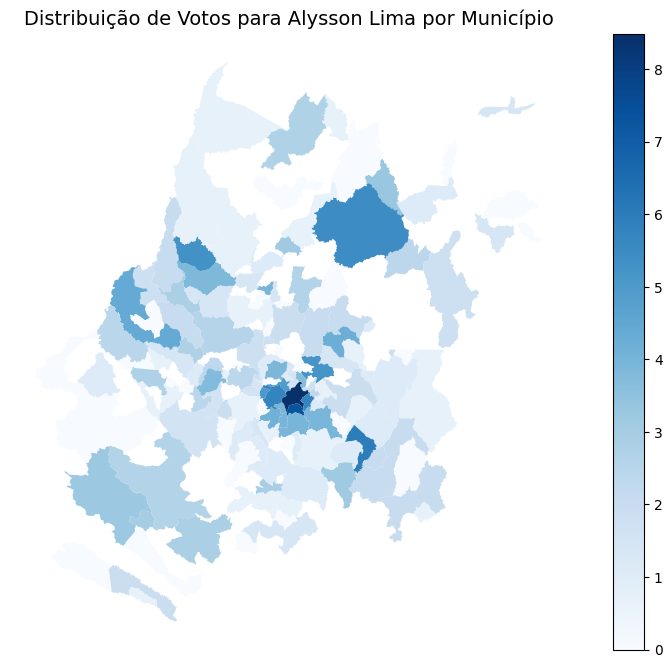

In [43]:
# Plotar o mapa coroplético
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Criar uma coluna logarítmica
geo_nao_eleito_connected = geo_nao_eleito.copy()
geo_nao_eleito_connected['QT_VOTOS_log'] = np.log(geo_nao_eleito_connected['QT_VOTOS'])

# Definir o colormap
vmin_log = np.log(geo_nao_eleito_connected['QT_VOTOS'].min())
vmax_log = np.log(geo_nao_eleito_connected['QT_VOTOS'].max())
norm = colors.Normalize(vmin=vmin_log, vmax=vmax_log)

geo_nao_eleito_connected.plot(
    column='QT_VOTOS_log',
    cmap='Blues',
    legend=True,
    ax=ax
)
ax.set_title('Distribuição de Votos para Alysson Lima por Município', fontsize=14)
ax.axis('off')
plt.show()

In [44]:
!pip install mapclassify

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 5.0 MB/s eta 0:00:00


QUESTÃO 3, LETRA B:

Nesta questão, foi utilizada uma API do IBGE para a divisão dos municípios em microrregiões

In [45]:
import requests
import pandas as pd

# URL da API do IBGE para obter todos os municípios com suas microrregiões
url = "https://servicodados.ibge.gov.br/api/v1/localidades/municipios"

# Requisição GET para obter os dados
response = requests.get(url)

if response.status_code == 200:
    # Carregar a resposta JSON em um DataFrame
    municipios = response.json()

    # Criar listas para armazenar os dados
    codigos_municipio = []
    nomes_municipio = []
    codigos_microrregiao = []
    nomes_microrregiao = []
    codigos_mesoregiao = []
    nomes_mesoregiao = []
    siglas_uf = []

    # Iterar sobre os municípios e extrair as informações desejadas
    for municipio in municipios:
        codigos_municipio.append(municipio["id"])
        nomes_municipio.append(municipio["nome"])
        codigos_microrregiao.append(municipio["microrregiao"]["id"])
        nomes_microrregiao.append(municipio["microrregiao"]["nome"])
        codigos_mesoregiao.append(municipio["microrregiao"]["mesorregiao"]["id"])
        nomes_mesoregiao.append(municipio["microrregiao"]["mesorregiao"]["nome"])
        siglas_uf.append(municipio["microrregiao"]["mesorregiao"]["UF"]["sigla"])

    # Criar um DataFrame com os dados coletados
    df = pd.DataFrame({
        "codigo_municipio": codigos_municipio,
        "nome_municipio": nomes_municipio,
        "codigo_microrregiao": codigos_microrregiao,
        "nome_microrregiao": nomes_microrregiao,
        "codigo_mesoregiao": codigos_mesoregiao,
        "nome_mesoregiao": nomes_mesoregiao,
        "sigla_uf": siglas_uf
    })

    # Filtrar apenas os municípios de Goiás
    df_goias = df[df['sigla_uf'] == 'GO']

    # Exibir as primeiras linhas do DataFrame filtrado
    print(df_goias.head())

    # Opcional: Salvar em um arquivo CSV para uso futuro
    df_goias.to_csv('municipios_goias_microrregioes.csv', index=False)
    print("Dados salvos em 'municipios_goias_microrregioes.csv'")
else:
    print(f"Erro na requisição: {response.status_code}")

      codigo_municipio      nome_municipio  codigo_microrregiao  \
5323           5200050     Abadia de Goiás                52010   
5324           5200100           Abadiânia                52012   
5325           5200134             Acreúna                52014   
5326           5200159           Adelândia                52009   
5327           5200175  Água Fria de Goiás                52012   

         nome_microrregiao  codigo_mesoregiao nome_mesoregiao sigla_uf  
5323               Goiânia               5203   Centro Goiano       GO  
5324   Entorno de Brasília               5204    Leste Goiano       GO  
5325  Vale do Rio dos Bois               5205      Sul Goiano       GO  
5326               Anicuns               5203   Centro Goiano       GO  
5327   Entorno de Brasília               5204    Leste Goiano       GO  
Dados salvos em 'municipios_goias_microrregioes.csv'


In [46]:
import pandas as pd

# Carregar os dados das microrregiões
try:
    microrregioes = pd.read_csv("municipios_goias_microrregioes.csv", encoding="utf-8")
    print("Dados de microrregiões carregados com sucesso!")
except Exception as e:
    print("Erro ao carregar os dados de microrregiões:", e)
    raise

# Exibir as primeiras linhas para verificar
print("\nDados de votação:")
print(df_candidatos.head())

print("\nDados de microrregiões:")
print(microrregioes.head())

# Verificar as colunas de cada dataset
print("\nColunas do dataset de votação:")
print(df_candidatos.columns)

print("\nColunas do dataset de microrregiões:")
print(microrregioes.columns)

Dados de microrregiões carregados com sucesso!

Dados de votação:
   NM_MUNICIPIO  NR_VOTAVEL                        NM_VOTAVEL  QT_VOTOS
63     ANAPOLIS        1320           HILVANY ARAUJO PINHEIRO         1
67     ANAPOLIS        9091  DAYANA MOREIRA GUIMARAES MARTINS         1
72        CERES        9091  DAYANA MOREIRA GUIMARAES MARTINS         2
77      GOIANIA        9091  DAYANA MOREIRA GUIMARAES MARTINS         1
79     CEZARINA        9091  DAYANA MOREIRA GUIMARAES MARTINS         2

Dados de microrregiões:
   codigo_municipio      nome_municipio  codigo_microrregiao  \
0           5200050     Abadia de Goiás                52010   
1           5200100           Abadiânia                52012   
2           5200134             Acreúna                52014   
3           5200159           Adelândia                52009   
4           5200175  Água Fria de Goiás                52012   

      nome_microrregiao  codigo_mesoregiao nome_mesoregiao sigla_uf  
0               Goiâni

In [47]:
# Normalizar os nomes das cidades nos dois datasets
# Remove espaços extras e converte para letras maiúsculas
df_candidatos["NM_MUNICIPIO"] = df_candidatos["NM_MUNICIPIO"].str.upper().str.strip()
microrregioes["nome_municipio"] = microrregioes["nome_municipio"].str.upper().str.strip()

# Dicionário para ajustar os nomes de cidades específicos
correcoes = {
    "SÃO JOÃO D'ALIANÇA": "SÃO JOÃO D' DA ALIANÇA",
    "SÍTIO D ABADIA": "SÍTIO D'ABADIA",
    "ANHANGUERA": "ANHANGUERA"  # Confirmado sem alterações
}

# Aplicar correções nos nomes do dataset de votação
df_candidatos["NM_MUNICIPIO"] = df_candidatos["NM_MUNICIPIO"].replace(correcoes)

# Unificar os dados de votação com os dados das microrregiões
votacao_microrregioes = pd.merge(
    df_candidatos,
    microrregioes,
    left_on="NM_MUNICIPIO",
    right_on="nome_municipio",
    how="left"
)

# Verificar os primeiros dados unificados
print(votacao_microrregioes[["NM_MUNICIPIO", "nome_municipio", "codigo_microrregiao", "nome_microrregiao"]].head())

# Verificar quais municípios ainda não foram associados
nao_associados = votacao_microrregioes[votacao_microrregioes["codigo_microrregiao"].isna()]
print(nao_associados[["NM_MUNICIPIO"]].drop_duplicates())

  NM_MUNICIPIO nome_municipio  codigo_microrregiao     nome_microrregiao
0     ANAPOLIS            NaN                  NaN                   NaN
1     ANAPOLIS            NaN                  NaN                   NaN
2        CERES          CERES              52006.0                 Ceres
3      GOIANIA            NaN                  NaN                   NaN
4     CEZARINA       CEZARINA              52014.0  Vale do Rio dos Bois
                NM_MUNICIPIO
0                   ANAPOLIS
3                    GOIANIA
11                     JATAI
13                  LUZIANIA
14                 NEROPOLIS
...                      ...
6525   SANTA TEREZA DE GOIAS
7533          PILAR DE GOIAS
7707               IVOLANDIA
10449     CAMPESTRE DE GOIAS
14155         SITIO D ABADIA

[154 rows x 1 columns]


In [48]:
votacao_microrregioes = votacao_microrregioes.dropna(subset=["codigo_microrregiao"])
# Aqui foi retirada Sítio D' Abadia

In [49]:
# Agrupar os votos por microrregião
votos_por_microrregiao = votacao_microrregioes.groupby(
    ["codigo_microrregiao", "nome_microrregiao"]
)["QT_VOTOS"].sum().reset_index()

# Verificar os dados agregados
print(votos_por_microrregiao.head())

   codigo_microrregiao       nome_microrregiao  QT_VOTOS
0              52001.0  São Miguel do Araguaia      8349
1              52002.0            Rio Vermelho     19809
2              52003.0               Aragarças     10837
3              52004.0               Porangatu     55784
4              52005.0   Chapada dos Veadeiros     19966


In [50]:
# Recarregar o shapefile dos municípios de Goiás
import geopandas as gpd

microrregioes_geo = gpd.read_file("/content/GO_Municipios_2022.zip")

# Recarregar o dataset de microrregiões com informações adicionais
import pandas as pd

microrregioes = pd.read_csv("municipios_goias_microrregioes.csv")

# Garantir que as colunas usadas para o merge tenham o mesmo tipo
microrregioes_geo["CD_MUN"] = microrregioes_geo["CD_MUN"].astype(int)
microrregioes["codigo_municipio"] = microrregioes["codigo_municipio"].astype(int)

# Realizar a união entre os shapefiles e os dados de microrregiões
microrregioes_geo = microrregioes_geo.merge(
    microrregioes,
    left_on="CD_MUN",
    right_on="codigo_municipio",
    how="left"
)

# Verificar os resultados
print(microrregioes_geo.head())

    CD_MUN              NM_MUN SIGLA_UF  AREA_KM2  \
0  5200050     Abadia de Goiás       GO   143.357   
1  5200100           Abadiânia       GO  1044.555   
2  5200134             Acreúna       GO  1566.742   
3  5200159           Adelândia       GO   115.385   
4  5200175  Água Fria de Goiás       GO  2023.636   

                                            geometry  codigo_municipio  \
0  POLYGON ((-49.43754 -16.86015, -49.43849 -16.8...           5200050   
1  POLYGON ((-48.67246 -16.28556, -48.67248 -16.2...           5200100   
2  POLYGON ((-50.07007 -17.48691, -50.06993 -17.4...           5200134   
3  POLYGON ((-50.17913 -16.43049, -50.17928 -16.4...           5200159   
4  POLYGON ((-47.85694 -14.76464, -47.85674 -14.7...           5200175   

       nome_municipio  codigo_microrregiao     nome_microrregiao  \
0     Abadia de Goiás                52010               Goiânia   
1           Abadiânia                52012   Entorno de Brasília   
2             Acreúna           

In [51]:
# Garantir que as colunas usadas para o merge tenham o mesmo tipo
microrregioes_geo["CD_MUN"] = microrregioes_geo["CD_MUN"].astype(int)
microrregioes["codigo_municipio"] = microrregioes["codigo_municipio"].astype(int)

# Realizar a união
microrregioes_geo = microrregioes_geo.merge(
    microrregioes,
    left_on="CD_MUN",
    right_on="codigo_municipio",
    how="left"
)

# Verificar os resultados
print(microrregioes_geo.head())

    CD_MUN              NM_MUN SIGLA_UF  AREA_KM2  \
0  5200050     Abadia de Goiás       GO   143.357   
1  5200100           Abadiânia       GO  1044.555   
2  5200134             Acreúna       GO  1566.742   
3  5200159           Adelândia       GO   115.385   
4  5200175  Água Fria de Goiás       GO  2023.636   

                                            geometry  codigo_municipio_x  \
0  POLYGON ((-49.43754 -16.86015, -49.43849 -16.8...             5200050   
1  POLYGON ((-48.67246 -16.28556, -48.67248 -16.2...             5200100   
2  POLYGON ((-50.07007 -17.48691, -50.06993 -17.4...             5200134   
3  POLYGON ((-50.17913 -16.43049, -50.17928 -16.4...             5200159   
4  POLYGON ((-47.85694 -14.76464, -47.85674 -14.7...             5200175   

     nome_municipio_x  codigo_microrregiao_x   nome_microrregiao_x  \
0     Abadia de Goiás                  52010               Goiânia   
1           Abadiânia                  52012   Entorno de Brasília   
2             

In [53]:
# Ajustar o tipo de dados para garantir compatibilidade
votos_por_microrregiao["codigo_microrregiao"] = votos_por_microrregiao["codigo_microrregiao"].astype(int)

# Realizar a união com as colunas corrigidas
microrregioes_geo_votos = microrregioes_geo.merge(
    votos_por_microrregiao,
    left_on="codigo_microrregiao_x",
    right_on="codigo_microrregiao",
    how="left"
)

# Verificar os dados resultantes
print(microrregioes_geo_votos.head())

    CD_MUN              NM_MUN SIGLA_UF  AREA_KM2  \
0  5200050     Abadia de Goiás       GO   143.357   
1  5200100           Abadiânia       GO  1044.555   
2  5200134             Acreúna       GO  1566.742   
3  5200159           Adelândia       GO   115.385   
4  5200175  Água Fria de Goiás       GO  2023.636   

                                            geometry  codigo_municipio_x  \
0  POLYGON ((-49.43754 -16.86015, -49.43849 -16.8...             5200050   
1  POLYGON ((-48.67246 -16.28556, -48.67248 -16.2...             5200100   
2  POLYGON ((-50.07007 -17.48691, -50.06993 -17.4...             5200134   
3  POLYGON ((-50.17913 -16.43049, -50.17928 -16.4...             5200159   
4  POLYGON ((-47.85694 -14.76464, -47.85674 -14.7...             5200175   

     nome_municipio_x  codigo_microrregiao_x   nome_microrregiao_x  \
0     Abadia de Goiás                  52010               Goiânia   
1           Abadiânia                  52012   Entorno de Brasília   
2             

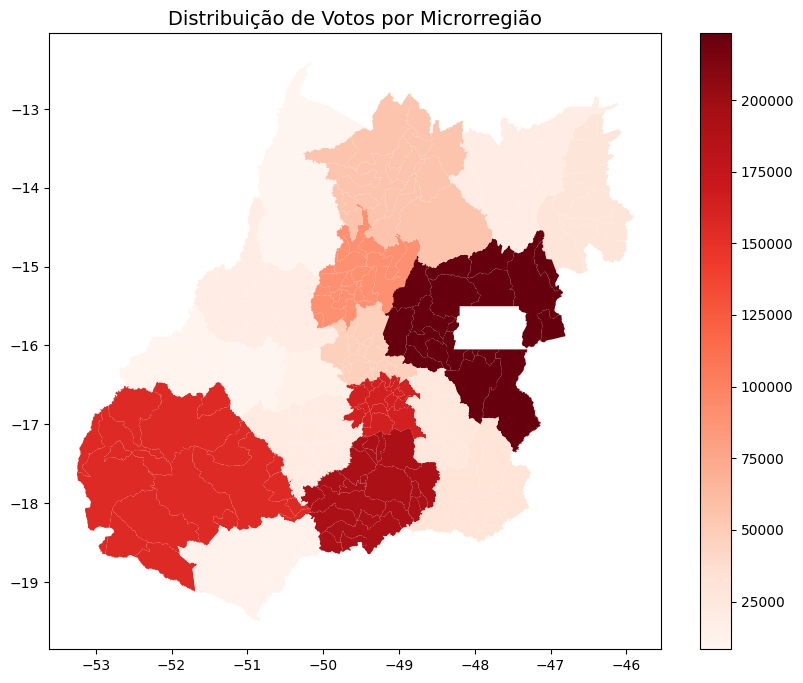

In [54]:
import matplotlib.pyplot as plt

# Criar um mapa temático com os votos por microrregião
microrregioes_geo_votos.plot(
    column="QT_VOTOS",  # Coluna para mapear os valores
    cmap="Reds",        # Paleta de cores
    legend=True,
    figsize=(10, 8)
)

# Adicionar título
plt.title("Distribuição de Votos por Microrregião", fontsize=14)
plt.show()

In [55]:
# Agregar os votos por microrregião e por candidato
votos_por_microrregiao_candidato = votacao_microrregioes.groupby(
    ["codigo_microrregiao", "nome_microrregiao", "NM_VOTAVEL"]
)["QT_VOTOS"].sum().reset_index()

In [57]:
# Ajustar o tipo de dados para compatibilidade
votos_por_microrregiao_candidato["codigo_microrregiao"] = votos_por_microrregiao_candidato["codigo_microrregiao"].astype(int)

# Realizar o merge novamente
microrregioes_geo_votos = microrregioes_geo.merge(
    votos_por_microrregiao_candidato,
    left_on="codigo_microrregiao_x",
    right_on="codigo_microrregiao",
    how="left"
)

# Verificar os dados finais
print(microrregioes_geo_votos.head())

    CD_MUN           NM_MUN SIGLA_UF  AREA_KM2  \
0  5200050  Abadia de Goiás       GO   143.357   
1  5200050  Abadia de Goiás       GO   143.357   
2  5200050  Abadia de Goiás       GO   143.357   
3  5200050  Abadia de Goiás       GO   143.357   
4  5200050  Abadia de Goiás       GO   143.357   

                                            geometry  codigo_municipio_x  \
0  POLYGON ((-49.43754 -16.86015, -49.43849 -16.8...             5200050   
1  POLYGON ((-49.43754 -16.86015, -49.43849 -16.8...             5200050   
2  POLYGON ((-49.43754 -16.86015, -49.43849 -16.8...             5200050   
3  POLYGON ((-49.43754 -16.86015, -49.43849 -16.8...             5200050   
4  POLYGON ((-49.43754 -16.86015, -49.43849 -16.8...             5200050   

  nome_municipio_x  codigo_microrregiao_x nome_microrregiao_x  \
0  Abadia de Goiás                  52010             Goiânia   
1  Abadia de Goiás                  52010             Goiânia   
2  Abadia de Goiás                  52010      

In [58]:
# Filtrar os dados de GUSTAVO GAYER MACHADO DE ARAUJO
votos_gayer_agrupados = microrregioes_geo_votos[microrregioes_geo_votos['NM_VOTAVEL'] == 'GUSTAVO GAYER MACHADO DE ARAUJO']

In [59]:
# Criar matriz de pesos espaciais
from libpysal.weights import Queen
weights_gayer = Queen.from_dataframe(votos_gayer_agrupados)

# Calcular o Índice de Moran
from esda.moran import Moran
votos_values = votos_gayer_agrupados['QT_VOTOS'].fillna(0).values
moran = Moran(votos_values, weights_gayer)

# Exibir os resultados
print(f"Índice de Moran: {moran.I}")
print(f"p-value: {moran.p_sim}")
print(f"z-score: {moran.z_sim}")

<ipython-input-59-045bafcf62a2>:3: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  weights_gayer = Queen.from_dataframe(votos_gayer_agrupados)


Índice de Moran: 0.6997734188261653
p-value: 0.001
z-score: 17.624178534889648


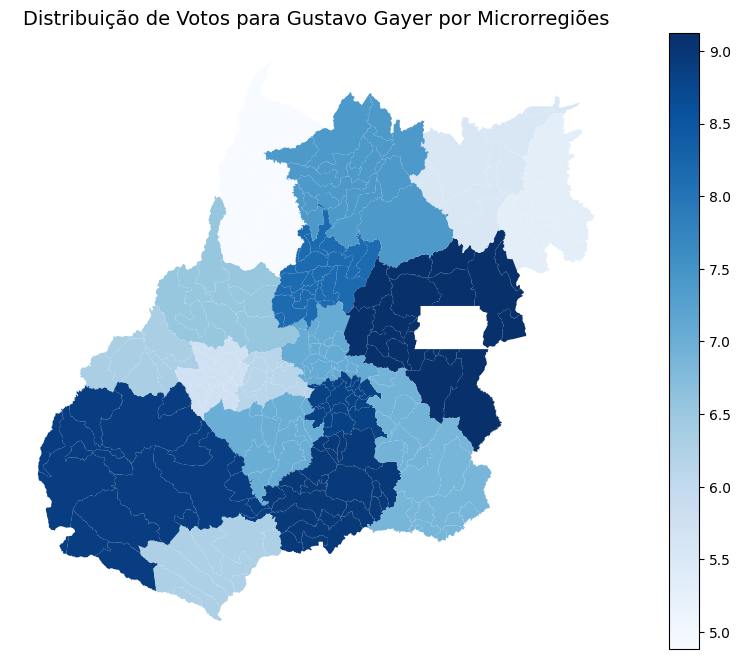

In [60]:
# Plotar o mapa coroplético
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Criar uma coluna logarítmica
votos_gayer_agrupados = votos_gayer_agrupados.copy()
votos_gayer_agrupados['QT_VOTOS_log'] = np.log(votos_gayer_agrupados['QT_VOTOS'])

# Definir o colormap
vmin_log = np.log(votos_gayer_agrupados['QT_VOTOS'].min())
vmax_log = np.log(votos_gayer_agrupados['QT_VOTOS'].max())
norm = colors.Normalize(vmin=vmin_log, vmax=vmax_log)

votos_gayer_agrupados.plot(
    column='QT_VOTOS_log',
    cmap='Blues',
    legend=True,
    ax=ax
)
ax.set_title('Distribuição de Votos para Gustavo Gayer por Microrregiões', fontsize=14)
ax.axis('off')
plt.show()

O comportamento geral da autocorrelação espacial foi preservado se comparado ao candidato Gustavo Gayer no item A, mas tornou-se mais evidente ao analisar em nível agregado (microrregiões). Isso reflete que a concentração geográfica dos votos de Gustavo Gayer é ainda mais marcada quando os dados são analisados em uma escala regional mais ampla, evidenciando possíveis focos de suporte concentrado.

In [61]:
# Filtrar os dados de ALYSSON FRANCISCO DE LIMA
votos_lima_agrupados = microrregioes_geo_votos[microrregioes_geo_votos['NM_VOTAVEL'] == 'ALYSSON FRANCISCO DE LIMA']

In [62]:
# Criar matriz de pesos espaciais
from libpysal.weights import Queen
weights_lima = Queen.from_dataframe(votos_lima_agrupados)

# Calcular o Índice de Moran
from esda.moran import Moran
votos_values = votos_lima_agrupados['QT_VOTOS'].fillna(0).values
moran = Moran(votos_values, weights_lima)

# Exibir os resultados
print(f"Índice de Moran: {moran.I}")
print(f"p-value: {moran.p_sim}")
print(f"z-score: {moran.z_sim}")

<ipython-input-62-e284a38dff16>:3: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  weights_lima = Queen.from_dataframe(votos_lima_agrupados)


Índice de Moran: 0.7295411668335001
p-value: 0.001
z-score: 18.502671334765406


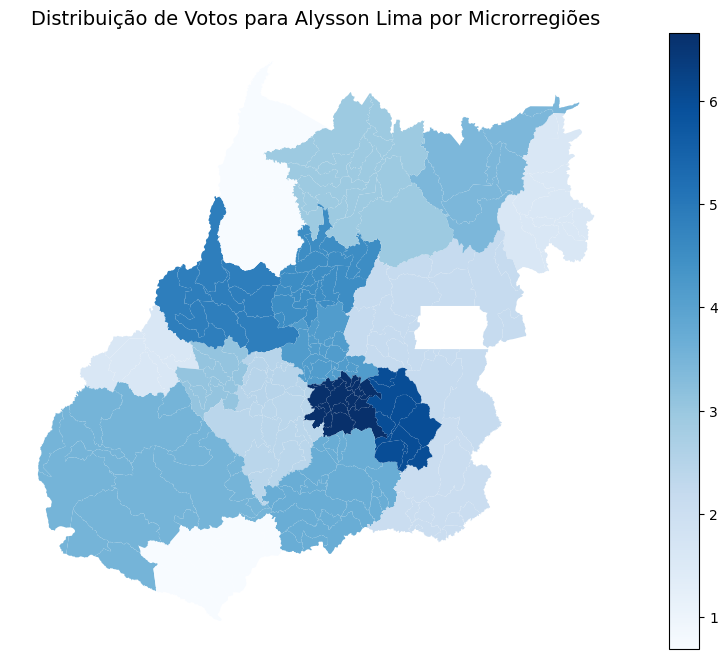

In [63]:
# Plotar o mapa coroplético
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Criar uma coluna logarítmica
votos_lima_agrupados = votos_lima_agrupados.copy()
votos_lima_agrupados['QT_VOTOS_log'] = np.log(votos_lima_agrupados['QT_VOTOS'])

# Definir o colormap
vmin_log = np.log(votos_lima_agrupados['QT_VOTOS'].min())
vmax_log = np.log(votos_lima_agrupados['QT_VOTOS'].max())
norm = colors.Normalize(vmin=vmin_log, vmax=vmax_log)

votos_lima_agrupados.plot(
    column='QT_VOTOS_log',
    cmap='Blues',
    legend=True,
    ax=ax
)
ax.set_title('Distribuição de Votos para Alysson Lima por Microrregiões', fontsize=14)
ax.axis('off')
plt.show()

No nível municipal, o Índice de Moran indica uma autocorrelação espacial moderada e estatisticamente significativa, sugerindo que municípios próximos possuem padrões semelhantes de votos para Alysson Francisco de Lima. No nível de microrregiões, o Índice de Moran apresenta um aumento, reforçando a autocorrelação espacial e evidenciando uma maior concentração de votos em regiões próximas quando os dados são agregados.

Essa intensificação no padrão ao nível de microrregiões demonstra que a votação de Alysson Francisco de Lima apresenta uma forte influência regional, possivelmente refletindo estratégias de campanha mais concentradas ou fatores geográficos e sociais que impactam a sua base eleitoral em áreas mais amplas.